In [5]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import njit
from scipy.ndimage import convolve, generate_binary_structure

In [6]:
#Define N, cria os lattices n e p, define getenergy
N = 50

init_random = np.random.random((N,N))
lattice_n = np.zeros((N, N))
lattice_n[init_random>=0.75] = 1
lattice_n[init_random<0.75] = -1

init_random = np.random.random((N,N))
lattice_p = np.zeros((N, N))
lattice_p[init_random>=0.25] = 1
lattice_p[init_random<0.25] = -1

def get_energy(lattice):
    # applies the nearest neighbours summation
    kern = generate_binary_structure(2, 1)
    kern[1][1] = False
    arr = -lattice * convolve(lattice, kern, mode='constant', cval=0)
    return arr.sum()


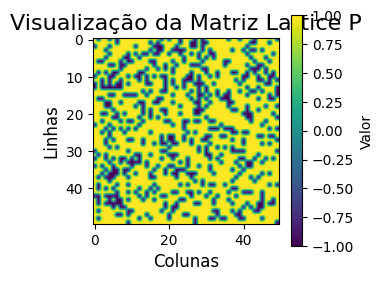

In [11]:
# Plotar a matriz lattice_p
plt.figure(figsize=(3, 3))  # Ajustar o tamanho da figura para melhor visualização
plt.imshow(lattice_p, cmap='viridis', interpolation='bilinear')  # Adicionar mapa de cores
plt.colorbar(label='Valor')  # Adicionar a barra de cores com rótulo

# Adicionar título e rótulos aos eixos
plt.title('Visualização da Matriz Lattice P', fontsize=16)
plt.xlabel('Colunas', fontsize=12)
plt.ylabel('Linhas', fontsize=12)

# Exibir o gráfico
plt.show()

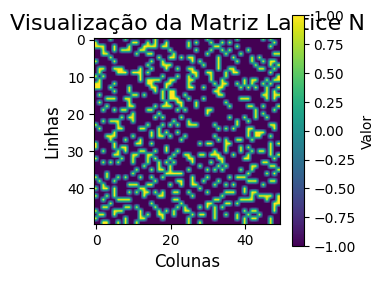

In [12]:
# Plotar a matriz lattice_p
plt.figure(figsize=(3, 3))  # Ajustar o tamanho da figura para melhor visualização
plt.imshow(lattice_n, cmap='viridis', interpolation='bilinear')  # Adicionar mapa de cores
plt.colorbar(label='Valor')  # Adicionar a barra de cores com rótulo

# Adicionar título e rótulos aos eixos
plt.title('Visualização da Matriz Lattice N', fontsize=16)
plt.xlabel('Colunas', fontsize=12)
plt.ylabel('Linhas', fontsize=12)

# Exibir o gráfico
plt.show()

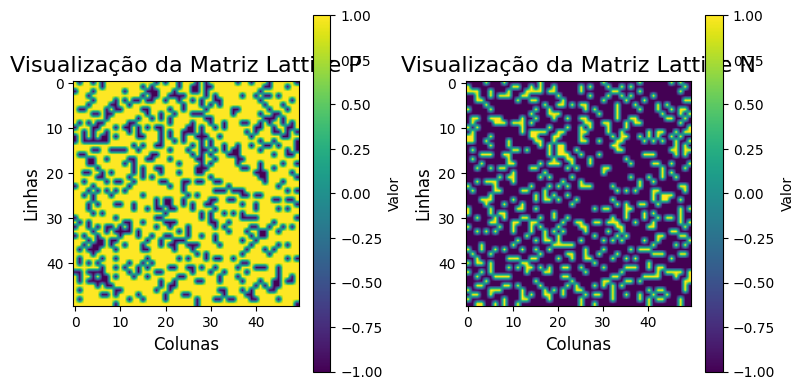

In [13]:
# Criar uma figura com dois subplots (um para cada matriz)
fig, ax = plt.subplots(1, 2, figsize=(8, 4))  # 1 linha, 2 colunas

# Plotar a matriz lattice_p
cax1 = ax[0].imshow(lattice_p, cmap='viridis', interpolation='bilinear')
fig.colorbar(cax1, ax=ax[0], label='Valor')  # Adicionar a barra de cores com rótulo no subplot da esquerda
ax[0].set_title('Visualização da Matriz Lattice P', fontsize=16)
ax[0].set_xlabel('Colunas', fontsize=12)
ax[0].set_ylabel('Linhas', fontsize=12)

# Plotar a matriz lattice_n
cax2 = ax[1].imshow(lattice_n, cmap='viridis', interpolation='bilinear')
fig.colorbar(cax2, ax=ax[1], label='Valor')  # Adicionar a barra de cores com rótulo no subplot da direita
ax[1].set_title('Visualização da Matriz Lattice N', fontsize=16)
ax[1].set_xlabel('Colunas', fontsize=12)
ax[1].set_ylabel('Linhas', fontsize=12)

# Ajustar layout para evitar sobreposição
plt.tight_layout()

# Exibir o gráfico
plt.show()


In [16]:
#Obtem energia do lattice P
get_energy(lattice_p)

-2384.0

In [18]:
def metropolis(spin_arr, times, BJ, energy):
    spin_arr = spin_arr.copy()
    net_spins = np.zeros(times-1)
    net_energy = np.zeros(times-1)
    for t in range(0,times-1):
        # 2. pick random point on array and flip spin
        x = np.random.randint(0,N)
        y = np.random.randint(0,N)
        spin_i = spin_arr[x,y] #initial spin
        spin_f = spin_i*-1 #proposed spin flip

        # compute change in energy
        E_i = 0
        E_f = 0
        if x>0:
            E_i += -spin_i*spin_arr[x-1,y]
            E_f += -spin_f*spin_arr[x-1,y]
        if x<N-1:
            E_i += -spin_i*spin_arr[x+1,y]
            E_f += -spin_f*spin_arr[x+1,y]
        if y>0:
            E_i += -spin_i*spin_arr[x,y-1]
            E_f += -spin_f*spin_arr[x,y-1]
        if y<N-1:
            E_i += -spin_i*spin_arr[x,y+1]
            E_f += -spin_f*spin_arr[x,y+1]

        # 3 / 4. change state with designated probabilities
        dE = E_f-E_i
        if (dE>0)*(np.random.random() < np.exp(-BJ*dE)):
            spin_arr[x,y]=spin_f
            energy += dE
        elif dE<=0:
            spin_arr[x,y]=spin_f
            energy += dE

        net_spins[t] = spin_arr.sum()
        net_energy[t] = energy

    return net_spins, net_energy

In [9]:
spins, energies = metropolis(lattice_n, 1000000, 0.2, get_energy(lattice_n))

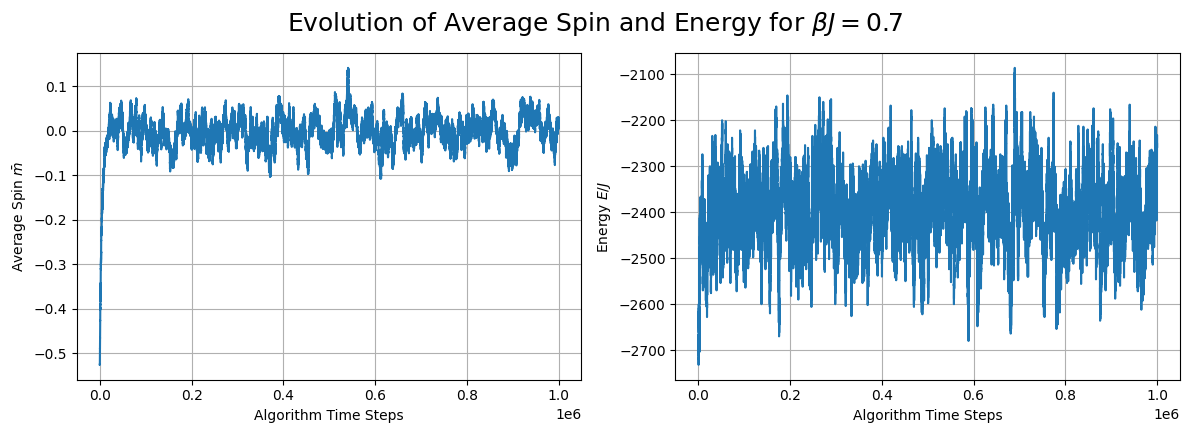

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
ax = axes[0]
ax.plot(spins/N**2)
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Average Spin $\bar{m}$')
ax.grid()
ax = axes[1]
ax.plot(energies)
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Energy $E/J$')
ax.grid()
fig.tight_layout()
fig.suptitle(r'Evolution of Average Spin and Energy for $\beta J=$0.7', y=1.07, size=18)
plt.show()

In [11]:
def get_spin_energy(lattice, BJs):
    ms = np.zeros(len(BJs))
    E_means = np.zeros(len(BJs))
    E_stds = np.zeros(len(BJs))
    for i, bj in enumerate(BJs):
        spins, energies = metropolis(lattice, 100000, bj, get_energy(lattice))
        ms[i] = spins[-100000:].mean()/N**2
        E_means[i] = energies[-100000:].mean()
        E_stds[i] = energies[-100000:].std()
    return ms, E_means, E_stds

BJs = np.arange(0.1, 2, 0.05)
ms_n, E_means_n, E_stds_n = get_spin_energy(lattice_n, BJs)
ms_p, E_means_p, E_stds_p = get_spin_energy(lattice_p, BJs)


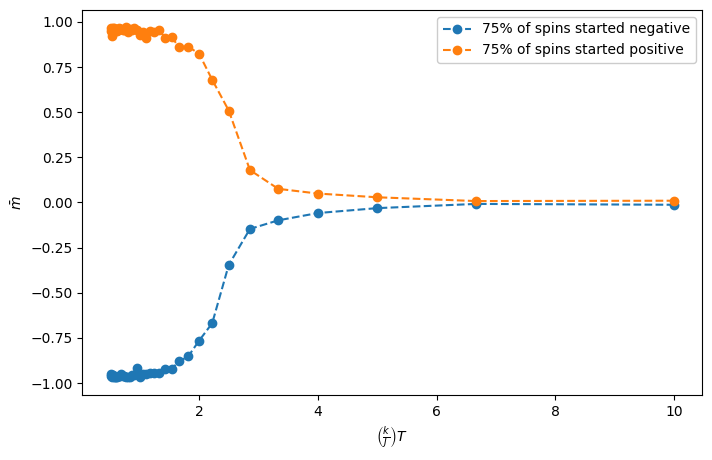

In [13]:
plt.figure(figsize=(8,5))
plt.plot(1/BJs, ms_n, 'o--', label='75% of spins started negative')
plt.plot(1/BJs, ms_p, 'o--', label='75% of spins started positive')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$\bar{m}$')
plt.legend(facecolor='white', framealpha=1)
plt.show()

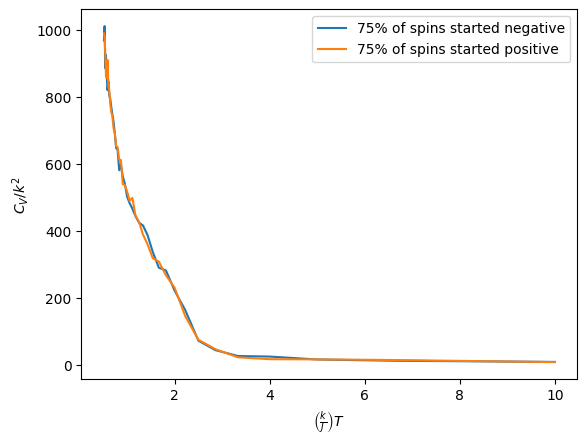

In [14]:
plt.plot(1/BJs, E_stds_n*BJs, label='75% of spins started negative')
plt.plot(1/BJs, E_stds_p*BJs, label='75% of spins started positive')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$C_V / k^2$')
plt.legend()
plt.show()

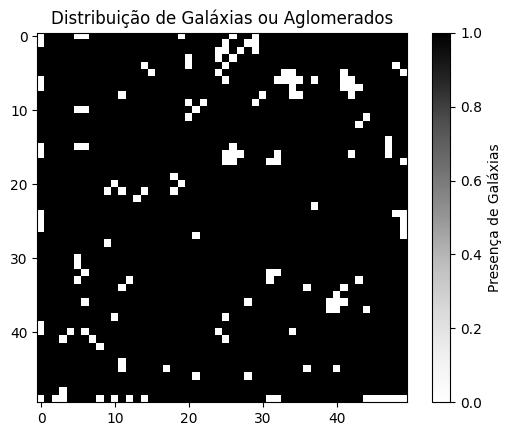

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve, generate_binary_structure

# Parâmetros
N = 50  # Tamanho da grade

# Gerar uma distribuição inicial aleatória de galáxias/aglomerados
# 0 representa vazio, 1 representa galáxia ou aglomerado
init_random = np.random.random((N, N))

# Definir o limiar para gerar galáxias/aglomerados
threshold = 0.2
lattice = np.zeros((N, N))
lattice[init_random >= threshold] = 1

# Gerar uma estrutura de vizinhança (p.ex., para conectar galáxias ou aglomerados)
# Isso pode representar a proximidade gravitacional ou qualquer outro critério de conexão
# Usar uma estrutura maior para uma visão mais abrangente
structure = generate_binary_structure(2, 1)  # Conectividade de 8 vizinhos

# Aplicar a convolução para simular a formação de filamentos ou estruturas maiores
convolved_lattice = convolve(lattice, structure, mode='constant', cval=0.0)

# Aplicar um limiar para visualizar estruturas conectadas
# Ajustar o limiar para destacar mais regiões conectadas
final_lattice = np.where(convolved_lattice > 2, 1, 0)

# Visualizar o resultado
plt.imshow(final_lattice, cmap='Greys', interpolation='none')
plt.title('Distribuição de Galáxias ou Aglomerados')
plt.colorbar(label='Presença de Galáxias')
plt.show()

In [12]:
import numpy as np
from scipy.ndimage import convolve, generate_binary_structure

def get_energy(lattice):
    # Define a estrutura de vizinhança (8 vizinhos)
    structure = generate_binary_structure(2, 1)  # Conectividade de 8 vizinhos
    
    # Convoluir a matriz com a estrutura de vizinhança
    interaction_sum = convolve(lattice, structure, mode='constant', cval=0)
    
    # Calcular a energia: soma das interações entre vizinhos
    # A interação é contada duas vezes, então dividimos o resultado por 2
    energy = -0.5 * np.sum(lattice * interaction_sum)
    
    return energy

# Parâmetros
N = 50  # Tamanho da grade

# Gerar uma distribuição inicial aleatória de galáxias/aglomerados
init_random = np.random.random((N, N))
threshold = 0.2
lattice = np.zeros((N, N))
lattice[init_random >= threshold] = 1
lattice[init_random < threshold] = -1

# Calcular e imprimir a energia
energy = get_energy(lattice)
print(f"Energia da configuração: {energy}")

Energia da configuração: -3080.0


In [22]:
import numpy as np
from numba import njit

def metropolis(spins, num_iterations, BJ, initial_energy):
    L = spins.shape[0]
    energies = []
    total_spins = []
    current_energy = initial_energy
    
    for _ in range(num_iterations):
        # Escolha aleatória de um spin
        i, j = np.random.randint(0, L, size=2)
        
        # Cálculo da energia de troca
        delta_E = 2 * spins[i, j] * (
            spins[(i+1)%L, j] + spins[i, (j+1)%L] + spins[(i-1)%L, j] + spins[i, (j-1)%L]
        ) * BJ
        
        # Aceitar ou rejeitar a mudança
        if delta_E < 0 or np.random.rand() < np.exp(-delta_E):
            spins[i, j] *= -1
            current_energy += delta_E
        
        # Salvar os valores atuais
        energies.append(current_energy)
        total_spins.append(np.sum(spins))
    
    return np.array(total_spins), np.array(energies)

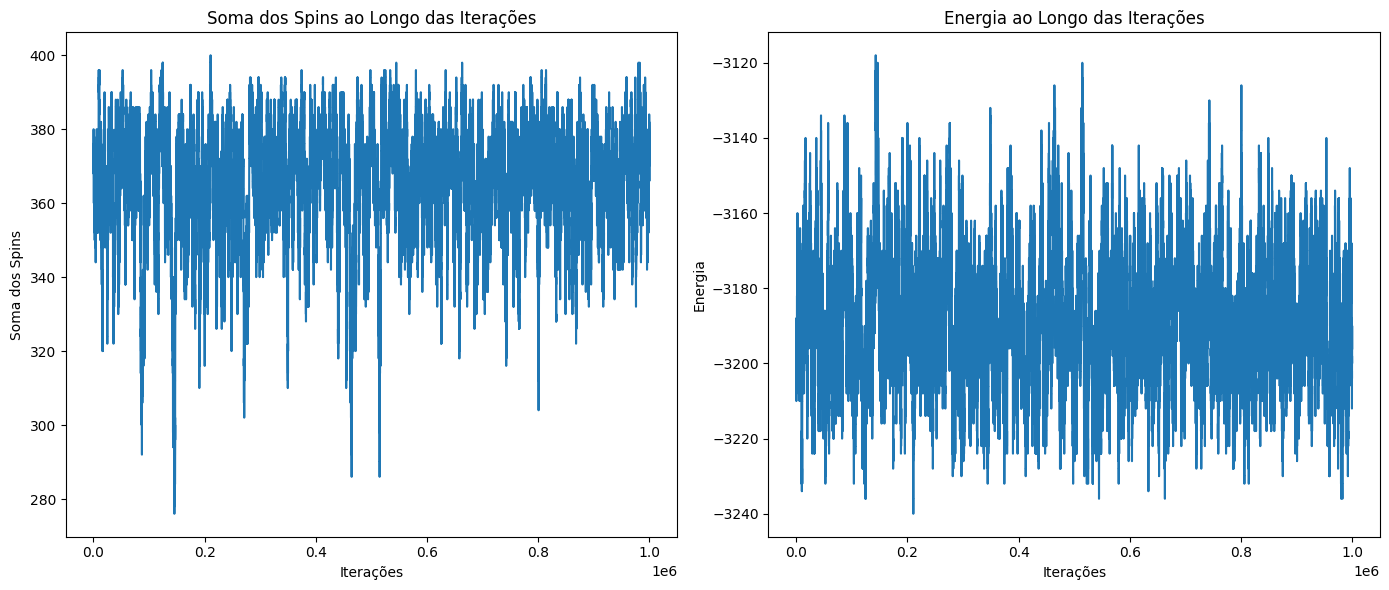

In [26]:
# Executar a simulação
spins, energies = metropolis(spin_arr, num_iterations, BJ, initial_energy)

# Visualizar a soma dos spins e a energia
plt.figure(figsize=(14, 6))

# Plotar a soma dos spins ao longo das iterações
plt.subplot(1, 2, 1)
plt.plot(spins[:num_iterations])
plt.title('Soma dos Spins ao Longo das Iterações')
plt.xlabel('Iterações')
plt.ylabel('Soma dos Spins')

# Plotar a energia ao longo das iterações
plt.subplot(1, 2, 2)
plt.plot(energies[:num_iterations])
plt.title('Energia ao Longo das Iterações')
plt.xlabel('Iterações')
plt.ylabel('Energia')

plt.tight_layout()
plt.show()

In [27]:

def get_spin_energy(lattice, BJs):
    ms = np.zeros(len(BJs))
    E_means = np.zeros(len(BJs))
    E_stds = np.zeros(len(BJs))

    # Parâmetros da simulação
    num_iterations = 100000  # Usar um número razoável de iterações

    for i, bj in enumerate(BJs):
        # Executar a simulação
        spins, energies = metropolis(lattice, num_iterations, bj, get_energy(lattice))
        
        # Calcular a média e o desvio padrão para a última parte da simulação
        ms[i] = spins[-num_iterations//10:].mean() / lattice.size
        E_means[i] = energies[-num_iterations//10:].mean()
        E_stds[i] = energies[-num_iterations//10:].std()

    return ms, E_means, E_stds

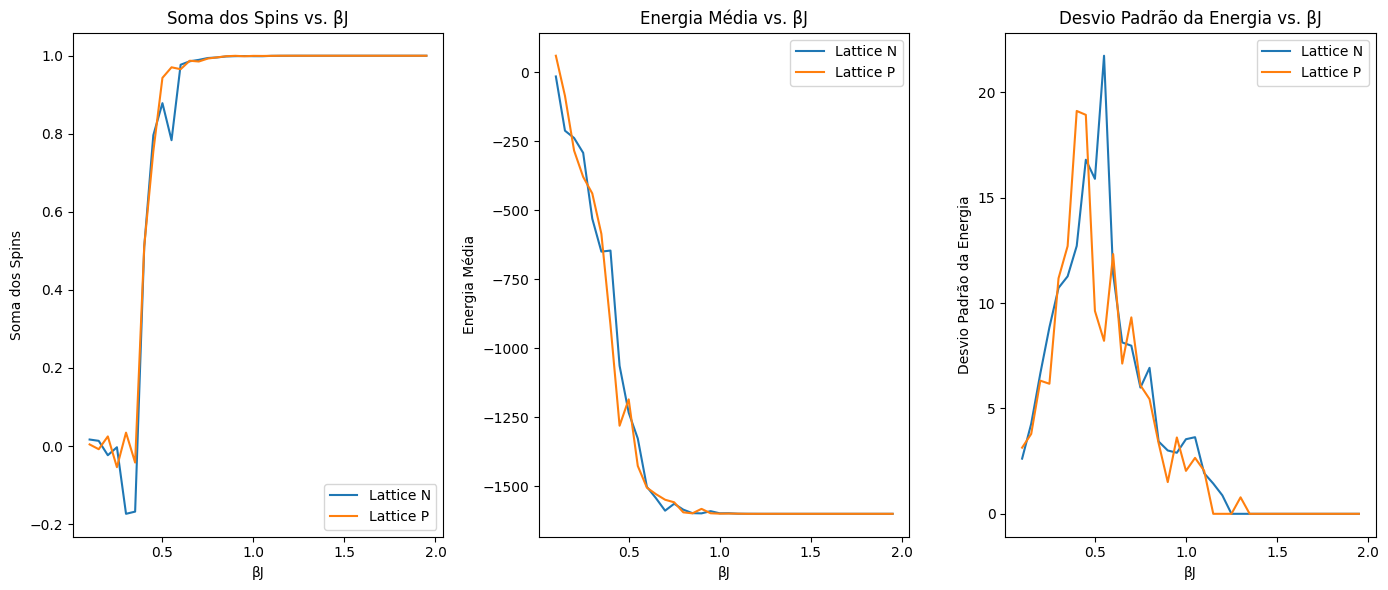

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def get_energy(lattice):
    # Esta função deve calcular a energia do sistema para uma configuração inicial
    # O cálculo depende do seu modelo específico. Aqui está uma implementação genérica.
    L = lattice.shape[0]
    E = 0
    for i in range(L):
        for j in range(L):
            S = lattice[i, j]
            # Soma dos vizinhos (modelo de Ising)
            nb_sum = lattice[(i+1)%L, j] + lattice[i, (j+1)%L] + lattice[(i-1)%L, j] + lattice[i, (j-1)%L]
            E -= nb_sum * S
    return E

def metropolis(lattice, num_iterations, BJ, initial_energy):
    L = lattice.shape[0]
    energies = []
    total_spins = []
    current_energy = initial_energy
    
    for _ in range(num_iterations):
        # Escolha aleatória de um spin
        i, j = np.random.randint(0, L, size=2)
        
        # Cálculo da energia de troca
        delta_E = 2 * lattice[i, j] * (
            lattice[(i+1)%L, j] + lattice[i, (j+1)%L] + lattice[(i-1)%L, j] + lattice[i, (j-1)%L]
        ) * BJ
        
        # Aceitar ou rejeitar a mudança
        if delta_E < 0 or np.random.rand() < np.exp(-delta_E):
            lattice[i, j] *= -1
            current_energy += delta_E
        
        # Salvar os valores atuais
        energies.append(current_energy)
        total_spins.append(np.sum(lattice))
    
    return np.array(total_spins), np.array(energies)

# Parâmetros de simulação
L = 20  # Tamanho da matriz
N = L * L  # Número total de spins

# Configurações de exemplo para as matrizes de spins
np.random.seed(0)
lattice_n = np.random.choice([-1, 1], size=(L, L))
lattice_p = np.random.choice([-1, 1], size=(L, L))

# Valores de beta * J a serem testados
BJs = np.arange(0.1, 2, 0.05)

# Obter propriedades para diferentes valores de beta * J
ms_n, E_means_n, E_stds_n = get_spin_energy(lattice_n, BJs)
ms_p, E_means_p, E_stds_p = get_spin_energy(lattice_p, BJs)

# Visualização dos resultados
plt.figure(figsize=(14, 6))

# Soma dos spins
plt.subplot(1, 3, 1)
plt.plot(BJs, ms_n, label='Lattice N')
plt.plot(BJs, ms_p, label='Lattice P')
plt.title('Soma dos Spins vs. βJ')
plt.xlabel('βJ')
plt.ylabel('Soma dos Spins')
plt.legend()

# Energia média
plt.subplot(1, 3, 2)
plt.plot(BJs, E_means_n, label='Lattice N')
plt.plot(BJs, E_means_p, label='Lattice P')
plt.title('Energia Média vs. βJ')
plt.xlabel('βJ')
plt.ylabel('Energia Média')
plt.legend()

# Desvio padrão da energia
plt.subplot(1, 3, 3)
plt.plot(BJs, E_stds_n, label='Lattice N')
plt.plot(BJs, E_stds_p, label='Lattice P')
plt.title('Desvio Padrão da Energia vs. βJ')
plt.xlabel('βJ')
plt.ylabel('Desvio Padrão da Energia')
plt.legend()

plt.tight_layout()
plt.show()